In [10]:
import pandas as pd
import re
from tqdm import tqdm
import time
import seaborn as sns
import joblib

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold

## Cresci data
Found to be very imbalanced dataset

In [12]:
df = pd.read_csv('users_with_variables.csv')

In [13]:
### not a lot of genuine twitter users
print(len(df[df['db']=='genuine']))

437


In [14]:
## creating bot variable
df['bot'] = df['db'].apply(lambda x: 0 if x == 'genuine' else 1)
print(len(df))

5885


In [16]:
df_pred = df[['friends_count', 'total_tweets_15min', 'max_tweets_15min', 'min_tweets_15min', 'mean_word_count', 'std_word_count', 
              'mean_retweet_count','std_retweet_count', 'mean_mentions_count', 'std_mentions_count','mean_hashtag_count', 'std_hashtag_count',
              'mean_urls_count','std_urls_count', 'bot' ]]

## Caverlee data
# Data preprocessing

In [17]:
df = pd.read_csv('users_caverlee.csv')

In [18]:
df_pred = df[[ 'bot','following', 'followers', 'length_screen_name', 'length_description', 
             'max_tweets_15min', 'min_tweets_15min', 'std_tweets_15_min', 'mean_tweets_15min', 'mean_word_count','std_word_count', 'mean_mentions_count', 
             'std_mentions_count','mean_hashtag_count', 'std_hashtag_count', 'mean_urls_count','std_urls_count', 'followers_to_following']]

In [19]:
df_pred_caverlee = df_pred

In [20]:
df_X = df[[ 'following', 'followers', 'length_screen_name', 'length_description', 
             'max_tweets_15min', 'min_tweets_15min', 'std_tweets_15_min', 'mean_tweets_15min', 'mean_word_count','std_word_count', 'mean_mentions_count', 
             'std_mentions_count','mean_hashtag_count', 'std_hashtag_count', 'mean_urls_count','std_urls_count', 'followers_to_following']]

In [21]:
df_Y = df[['bot']]

In [23]:
len(df_X.columns)

17

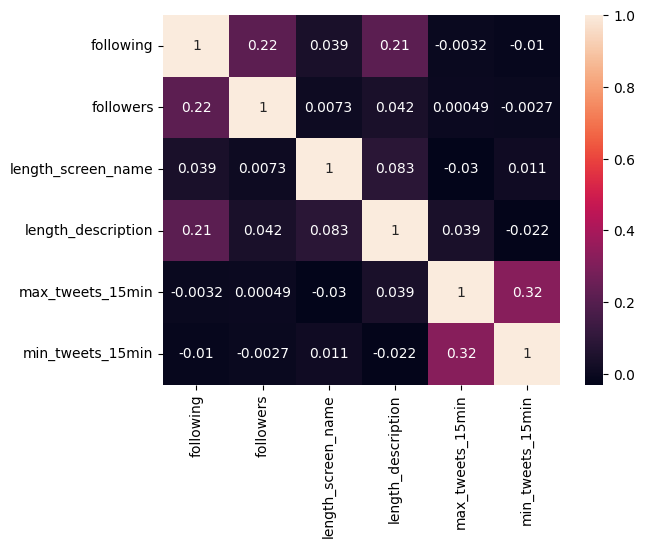

In [24]:
ax = sns.heatmap(df_X.iloc[:, range(0, 6)].corr(), annot=True)

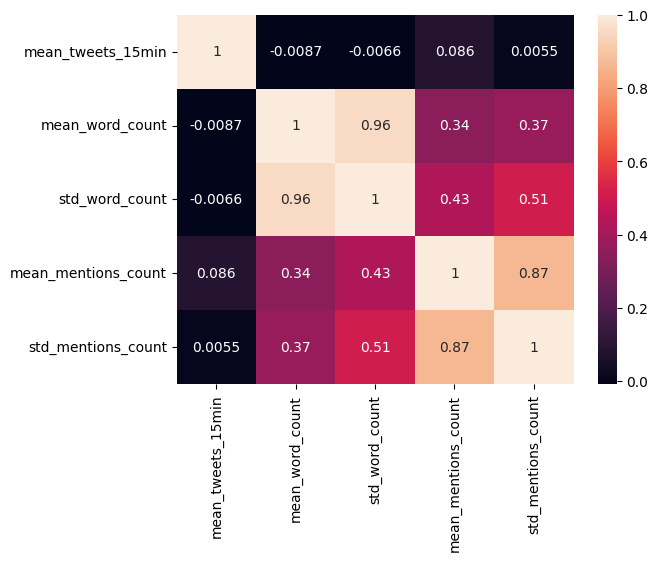

In [25]:
ax = sns.heatmap(df_X.iloc[:, range(7, 12)].corr(), annot=True)

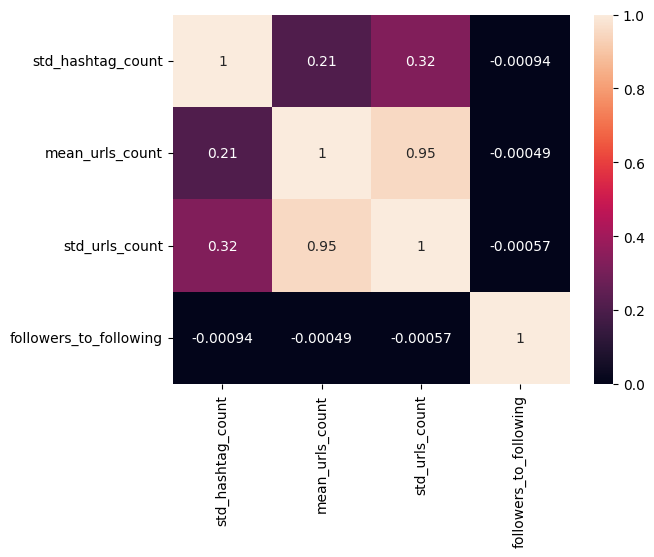

In [26]:
ax = sns.heatmap(df_X.iloc[:, range(13, 17)].corr(), annot=True)

In [27]:
df_pred['std_word_count'].fillna(0, inplace=True)
df_pred['std_mentions_count'].fillna(0, inplace=True)
df_pred['std_hashtag_count'].fillna(0, inplace=True)
df_pred['std_urls_count'].fillna(0, inplace=True)
df_pred['std_tweets_15_min'].fillna(0, inplace=True)

/var/folders/cn/hl5lj7gd17bft8_srrs_2zvr0000gn/T/ipykernel_65788/310641739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['std_word_count'].fillna(0, inplace=True)
/var/folders/cn/hl5lj7gd17bft8_srrs_2zvr0000gn/T/ipykernel_65788/310641739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['std_mentions_count'].fillna(0, inplace=True)
/var/folders/cn/hl5lj7gd17bft8_srrs_2zvr0000gn/T/ipykernel_65788/310641739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [35]:
#### packages 

#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb

#Python standard libraries
import time

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200


# Prediction Baseline Model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_pred.drop('bot', axis=1), df_pred['bot'], test_size=0.2)

In [37]:
k = pd.DataFrame(y_test)
df_test = X_test.merge(k[['bot']], left_index=True, right_index=True, how='inner')

In [38]:
### fitting benchmark model

results_dict = {}

xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide'
                         )
xgbc0.fit(X_train , y_train)

default_params = {}
gparams = xgbc0.get_params()

In [40]:
#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

In [42]:
#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy='lossguide',
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learnin...
                         'max_cat_threshold': [None],
                         'max_cat_to_onehot': [None], 'max_delta_step': [None],
                         'max_depth': [None], 'max_leaves': [None],
                         'min_child_weight': [None], 'missing': [nan],
                         'monotone_constraints': [None],
                         'multi_strategy': [None], 'n_estimators': [None],
                         'n_jobs': [None], 'num_parallel_tree': [None],
                         'objective': ['binary:logistic'], ...},
             return_train_score=True, scoring='accuracy', verbose=1)

In [46]:
#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)

In [47]:
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

####unseen_predictions = clf0.predict(df_test.iloc[:,1:]) - still do not have such data
### confusion matric
### TN FP
### FN TP
### we need to be pretty sure that we have bots - less false positive 

In [48]:
cfm_train 

array([[14780,   601],
       [  500, 15966]])

In [49]:
cfm_test

array([[3489,  338],
       [ 332, 3803]])

In [49]:
### negative - genuine, positive - bot
### our aim - less false positive - less people who are genuine, but classified as bots

In [50]:
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)

print(accs_train, accs_test)

0.9654284547995101 0.9158502888721427


In [51]:
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

print(f1s_train_p1, f1s_train_p0)
print(f1s_test_p1, f1s_test_p0)
print('It could be seen that F1 score for bots is higher that for genuine users')

0.9666696939424212 0.9640911907635107
0.9190430159497341 0.9123953974895398
It could be seen that F1 score for bots is higher that for genuine users


In [53]:
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
test_ras

0.971569630787926

In [54]:
#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}

In [55]:
results_dict

{'xgbc0': {'iterable_parameter': nan,
  'classifier': GridSearchCV(cv=3,
               estimator=XGBClassifier(base_score=None, booster='gbtree',
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric='auc', feature_types=None,
                                       gamma=None, grow_policy='lossguide',
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learnin...
                           'max_cat_threshold': [None],
                           'max_cat_to_onehot': [None], 'max_delta_step': [None],
                           'max_d

# Coordinate Descent

In [56]:
### creating param_grid for search 
params = deepcopy(default_params)

param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [115,130,150,165,180,200,225,250,275,300],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [57]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=5)
    clf.fit(X_train, y_train.values.ravel())
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'test roc auc score': test_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 5 folds for each of 13 candidates, totalling 65 fits
iteration #1 finished in: 12.611078262329102 seconds
Fitting 5 folds for each of 12 candidates, totalling 60 fits
iteration #2 finished in: 25.57412314414978 seconds
Fitting 5 folds for each of 10 candidates, totalling 50 fits
iteration #3 finished in: 52.16202902793884 seconds
Fitting 5 folds for each of 10 candidates, totalling 50 fits
iteration #4 finished in: 36.24354887008667 seconds
Fitting 5 folds for each of 13 candidates, totalling 65 fits
iteration #5 finished in: 36.37984275817871 seconds
Fitting 5 folds for each of 13 candidates, totalling 65 fits
iteration #6 finished in: 56.702038049697876 seconds


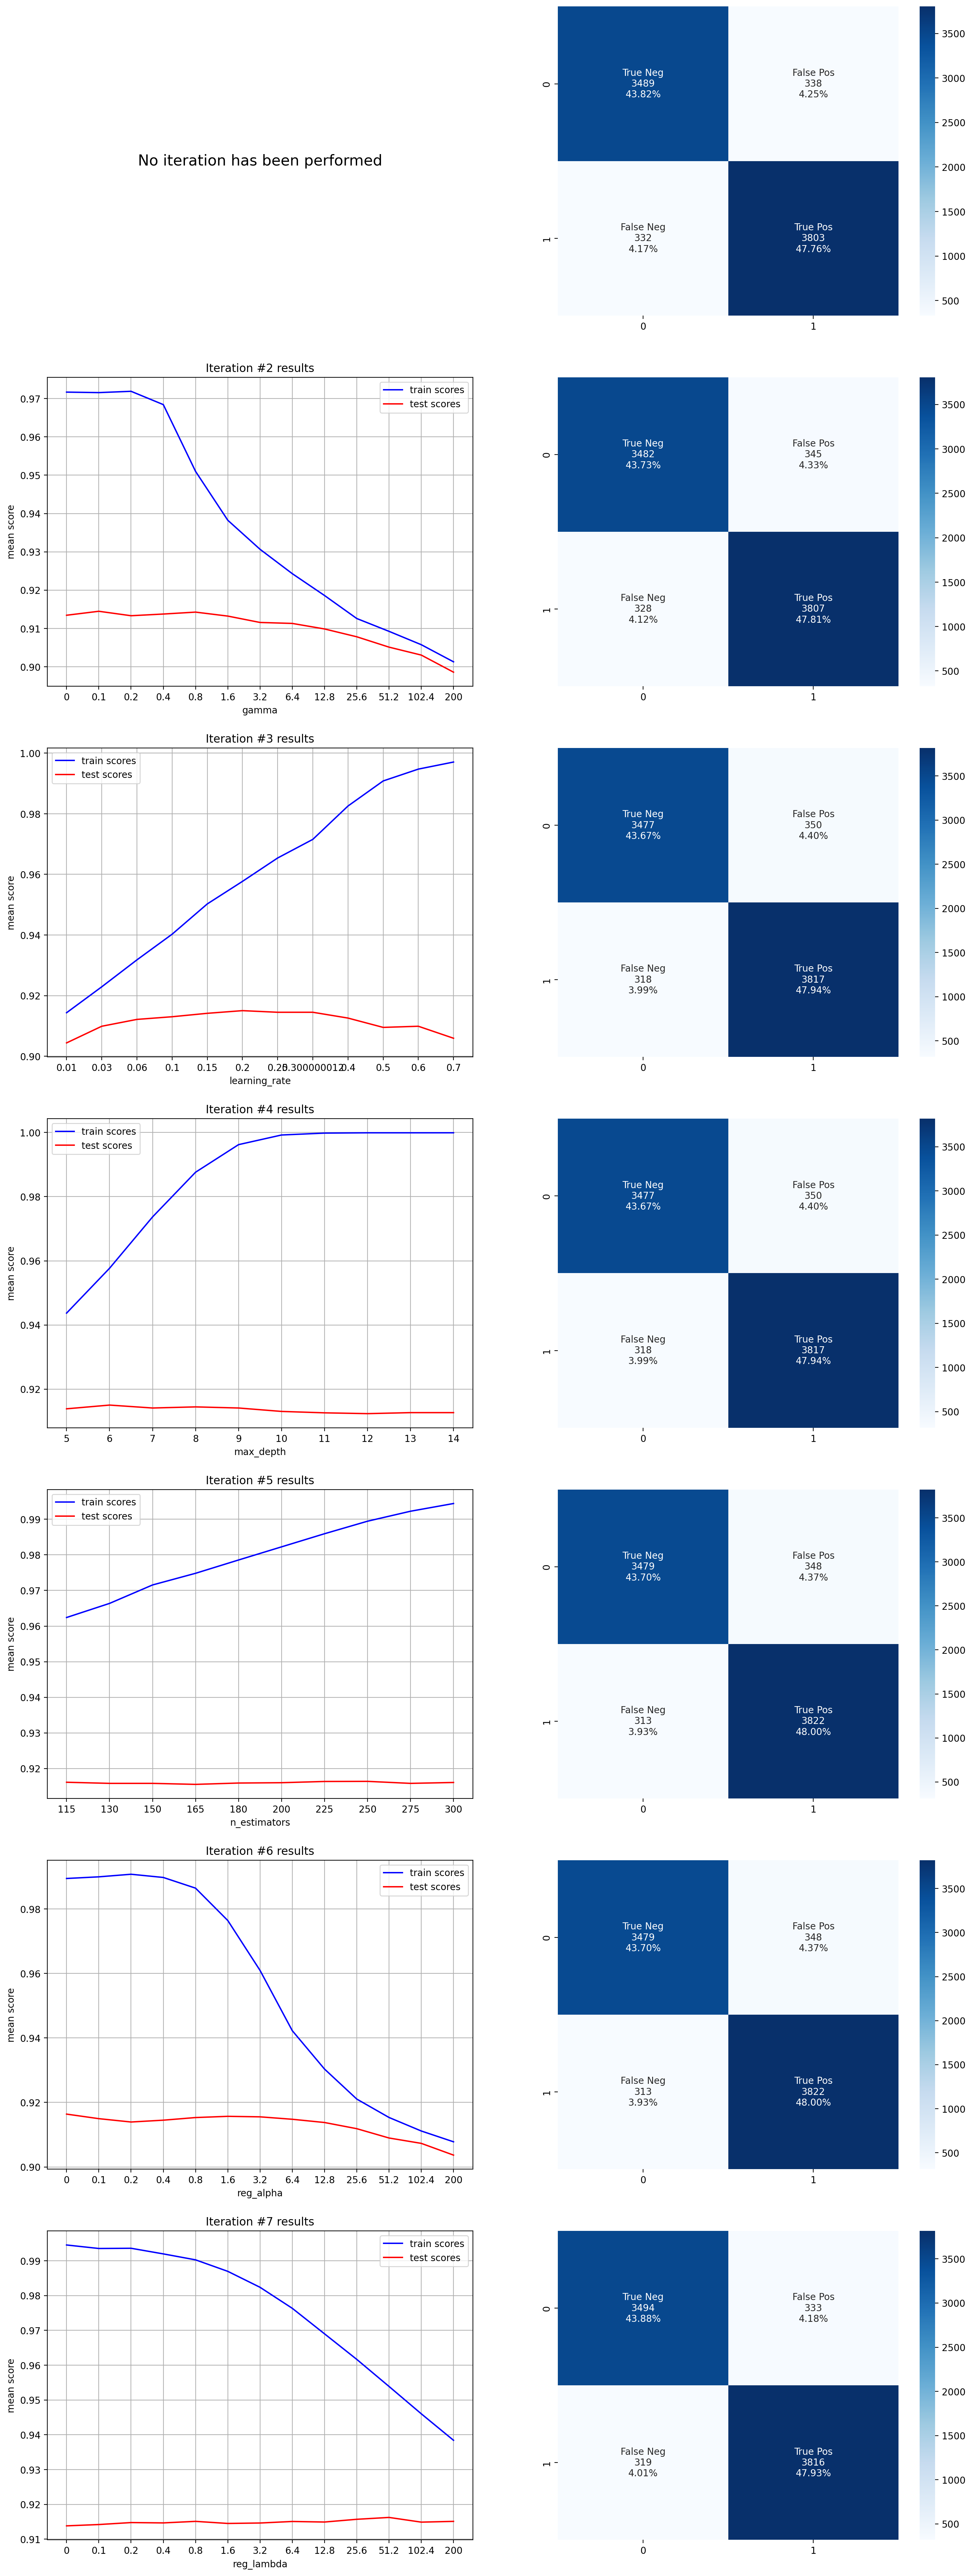

In [60]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,7*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();


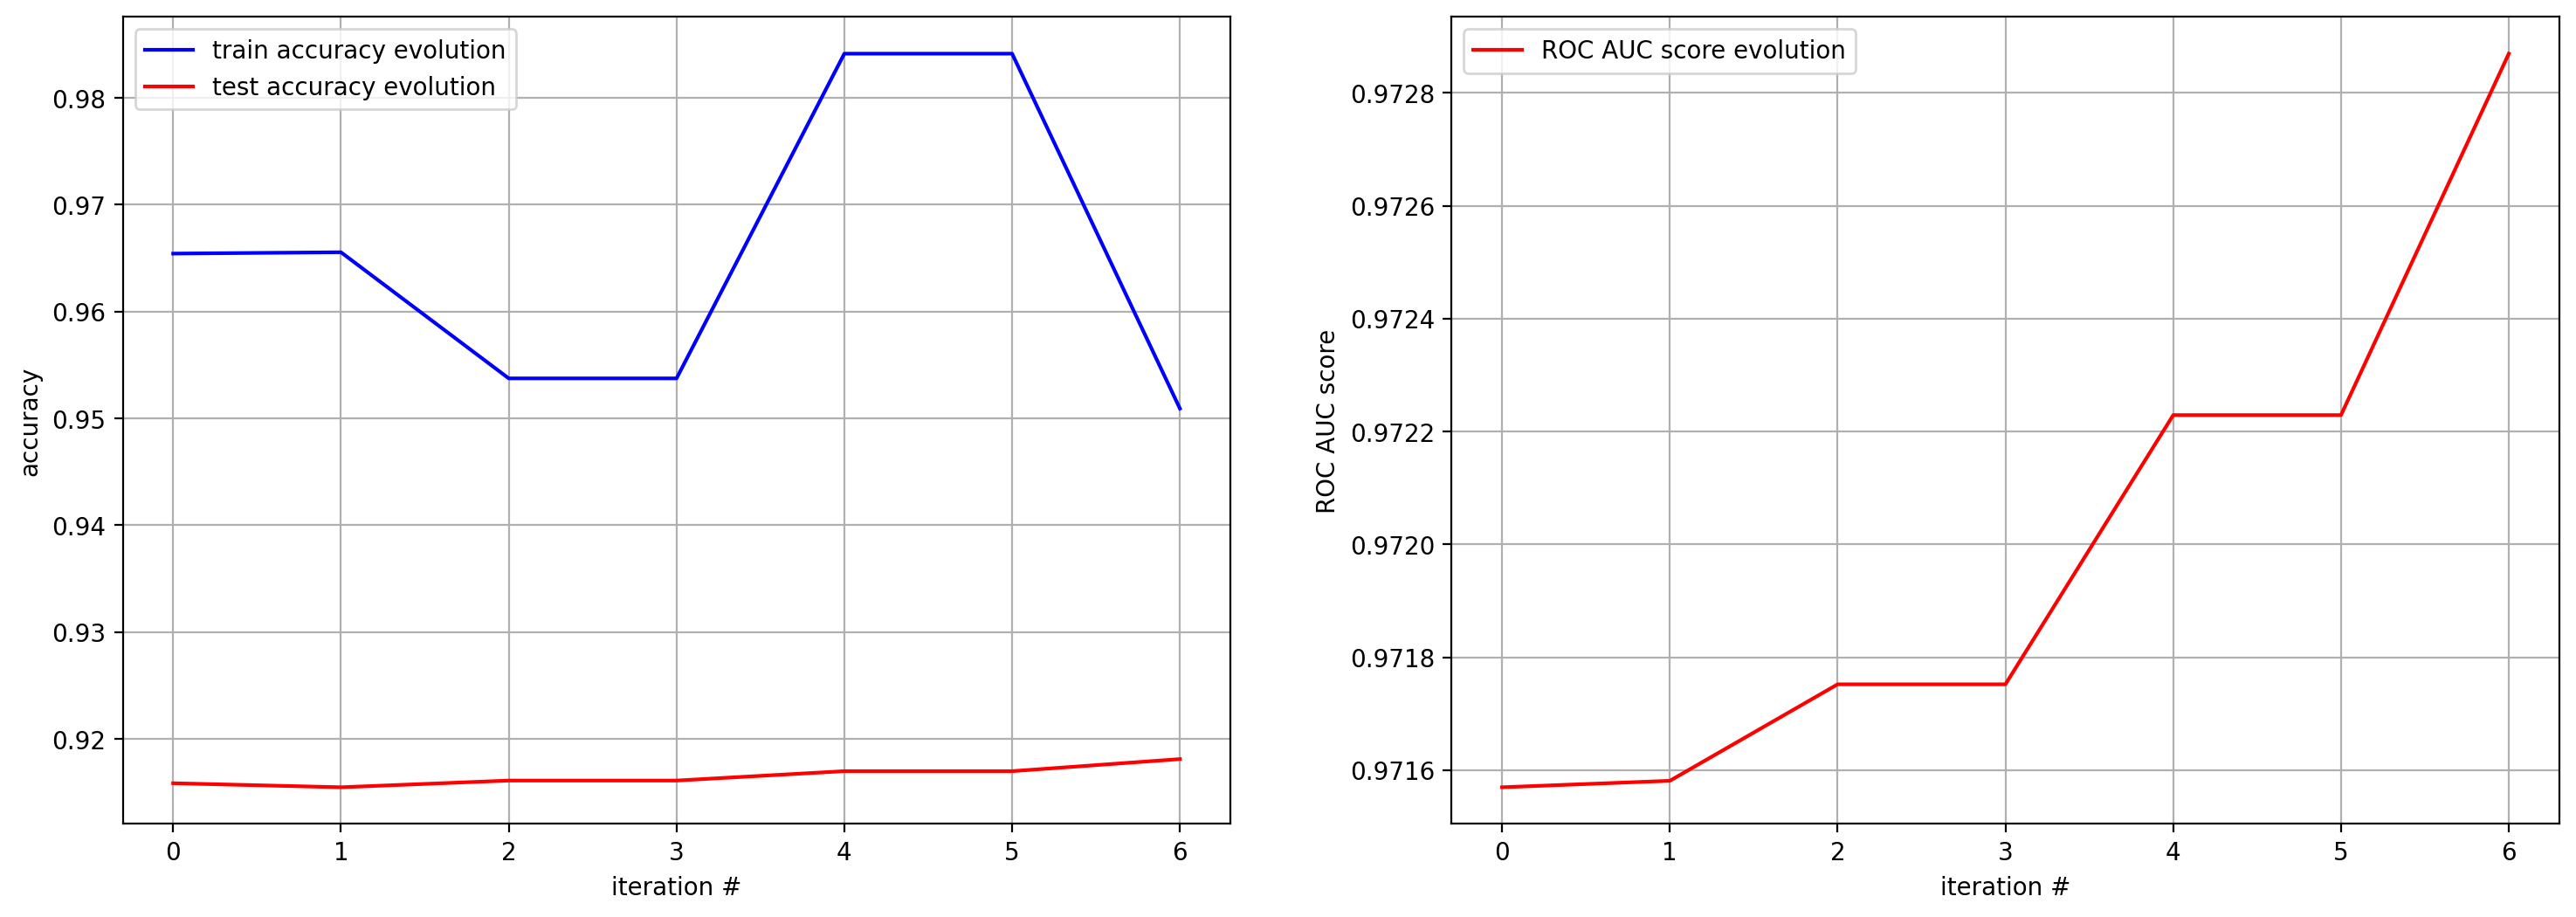

In [61]:
f, axes = plt.subplots(1,2,figsize=(18,6));

#plotting evolution of train/test accuracy scores for subsequent iterations
axes[0].plot([results_dict[key]['train_accuracy'] for key in results_dict.keys()], label='train accuracy evolution', color='blue');
axes[0].plot([results_dict[key]['test_accuracy'] for key in results_dict.keys()], label='test accuracy evolution', color='red');

#setting labels, drawing legend and major grid
axes[0].set_xlabel('iteration #');
axes[0].set_ylabel('accuracy');
axes[0].legend();
axes[0].grid('major');

#plotting evolution of test ROC AUC scores for subsequent iterations
axes[1].plot([results_dict[key]['test roc auc score'] for key in results_dict.keys()], label='ROC AUC score evolution', color='red');

#setting labels, drawing legend and major grid
axes[1].set_xlabel('iteration #');
axes[1].set_ylabel('ROC AUC score');
axes[1].legend();
axes[1].grid('major');

plt.show();

In gradient descent you have to manually choose model, since my aim in this task is to minimize false positives, I'm choosing a model with highest auc score - 6th itteration 

# Randomized search 

In [62]:
%%time

#start time
t0 = time.time()

#No. of jobs
rcvj = gcvj

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

CPU times: user 66 µs, sys: 273 µs, total: 339 µs
Wall time: 343 µs


In [64]:
%%time

#Executing Randomized Search
clf = RandomizedSearchCV(estimator=xgbc, param_distributions=param_grid, scoring='accuracy', return_train_score=True, verbose=1, cv=3, n_iter=rcvj)
clf.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 71 candidates, totalling 213 fits
CPU times: user 6min 52s, sys: 2min 18s, total: 9min 10s
Wall time: 1min 18s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy='lossguide',
                                           importance_type=None,
                                           interaction_constraints=None,
                                           l...
                                        'learning_rate': [0.01, 0.03, 0.06, 0.1,
                                                          0.15, 0.2, 0.25,
                                                          0.300000012, 0.4, 0.5,
                                                          0.6, 0.7],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'n_estimators': [115, 130, 150, 165,
                                                         180, 200, 225, 250,
                                                         275, 300],
                                        'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8,
                                                      1.6, 3.2, 6.4, 12.8, 25.6,
                                                      51.2, 102.4, 200],
                                        'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8,
                                                       1.6, 3.2, 6.4, 12.8,
                                                       25.6, 51.2, 102.4,
                                                       200]},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [65]:
import joblib

joblib.dump(clf, 'randomized_search_model.pkl')

['randomized_search_model.pkl']

In [66]:
%%time
    
#results dataframe
df = pd.DataFrame(clf.cv_results_)

CPU times: user 1.68 ms, sys: 3.06 ms, total: 4.74 ms
Wall time: 6.08 ms


In [67]:
cfm_test

array([[3494,  333],
       [ 319, 3816]])

In [68]:
%%time
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time

CPU times: user 319 ms, sys: 97.2 ms, total: 416 ms
Wall time: 95.9 ms


# Bayes search

In [104]:
%%time

#start time
t0 = time.time()

#No. of jobs
bcvj = int(gcvj)

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train, y_train)

#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)

    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_bcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
bcvt = t1 - t0

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=0.4, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=200, reg_lambda=0.4;, score=(train=0.906, test=0.907) total time=   0.2s
[CV 2/3] END gamma=0.4, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=200, reg_lambda=0.4;, score=(train=0.909, test=0.902) total time=   0.1s
[CV 3/3] END gamma=0.4, learning_rate=0.15, max_depth=8, n_estimators=150, reg_alpha=200, reg_lambda=0.4;, score=(train=0.907, test=0.901) total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=0.1, learning_rate=0.06, max_depth=10, n_estimators=200, reg_alpha=51.2, reg_lambda=1.6;, score=(train=0.916, test=0.911) total time=   0.7s
[CV 2/3] END gamma=0.1, learning_rate=0.06, max_depth=10, n_estimators=200, reg_alpha=51.2, reg_lambda=1.6;, score=(train=0.917, test=0.908) total time=   0.6s
[CV 3/3] END gamma=0.1, learning_rate=0.06, max_depth=10, n_estimators=200, reg_alpha=51

In [107]:
results_dict['xgbc_bcv']['best_params']

OrderedDict([('gamma', 0.4),
             ('learning_rate', 0.2),
             ('max_depth', 5),
             ('n_estimators', 225),
             ('reg_alpha', 0),
             ('reg_lambda', 12.8)])

In [108]:
#printing benchmark, iterative grid search, and randomized search ROC AUC / accuracy scores (test data set)
print(f"Benchmark AUC/accuracy score: {np.round(results_dict['xgbc0']['test roc auc score'],4)} / {np.round(results_dict['xgbc0']['test_accuracy'],4)}")
print(f"Coordinate descent AUC/accuracy score: {np.round(results_dict['xgbc6']['test roc auc score'],4)} / {np.round(results_dict['xgbc6']['test_accuracy'],4)}")
print(f"Randomized search AUC/accuracy score: {np.round(results_dict['xgbc_rcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_rcv']['test_accuracy'],4)}")
print(f"Bayes search AUC/accuracy score: {np.round(results_dict['xgbc_bcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_bcv']['test_accuracy'],4)}")

Benchmark AUC/accuracy score: 0.9716 / 0.9159
Coordinate descent AUC/accuracy score: 0.9729 / 0.9181
Randomized search AUC/accuracy score: 0.9721 / 0.9165
Bayes search AUC/accuracy score: 0.9724 / 0.9171



# Models Summary 

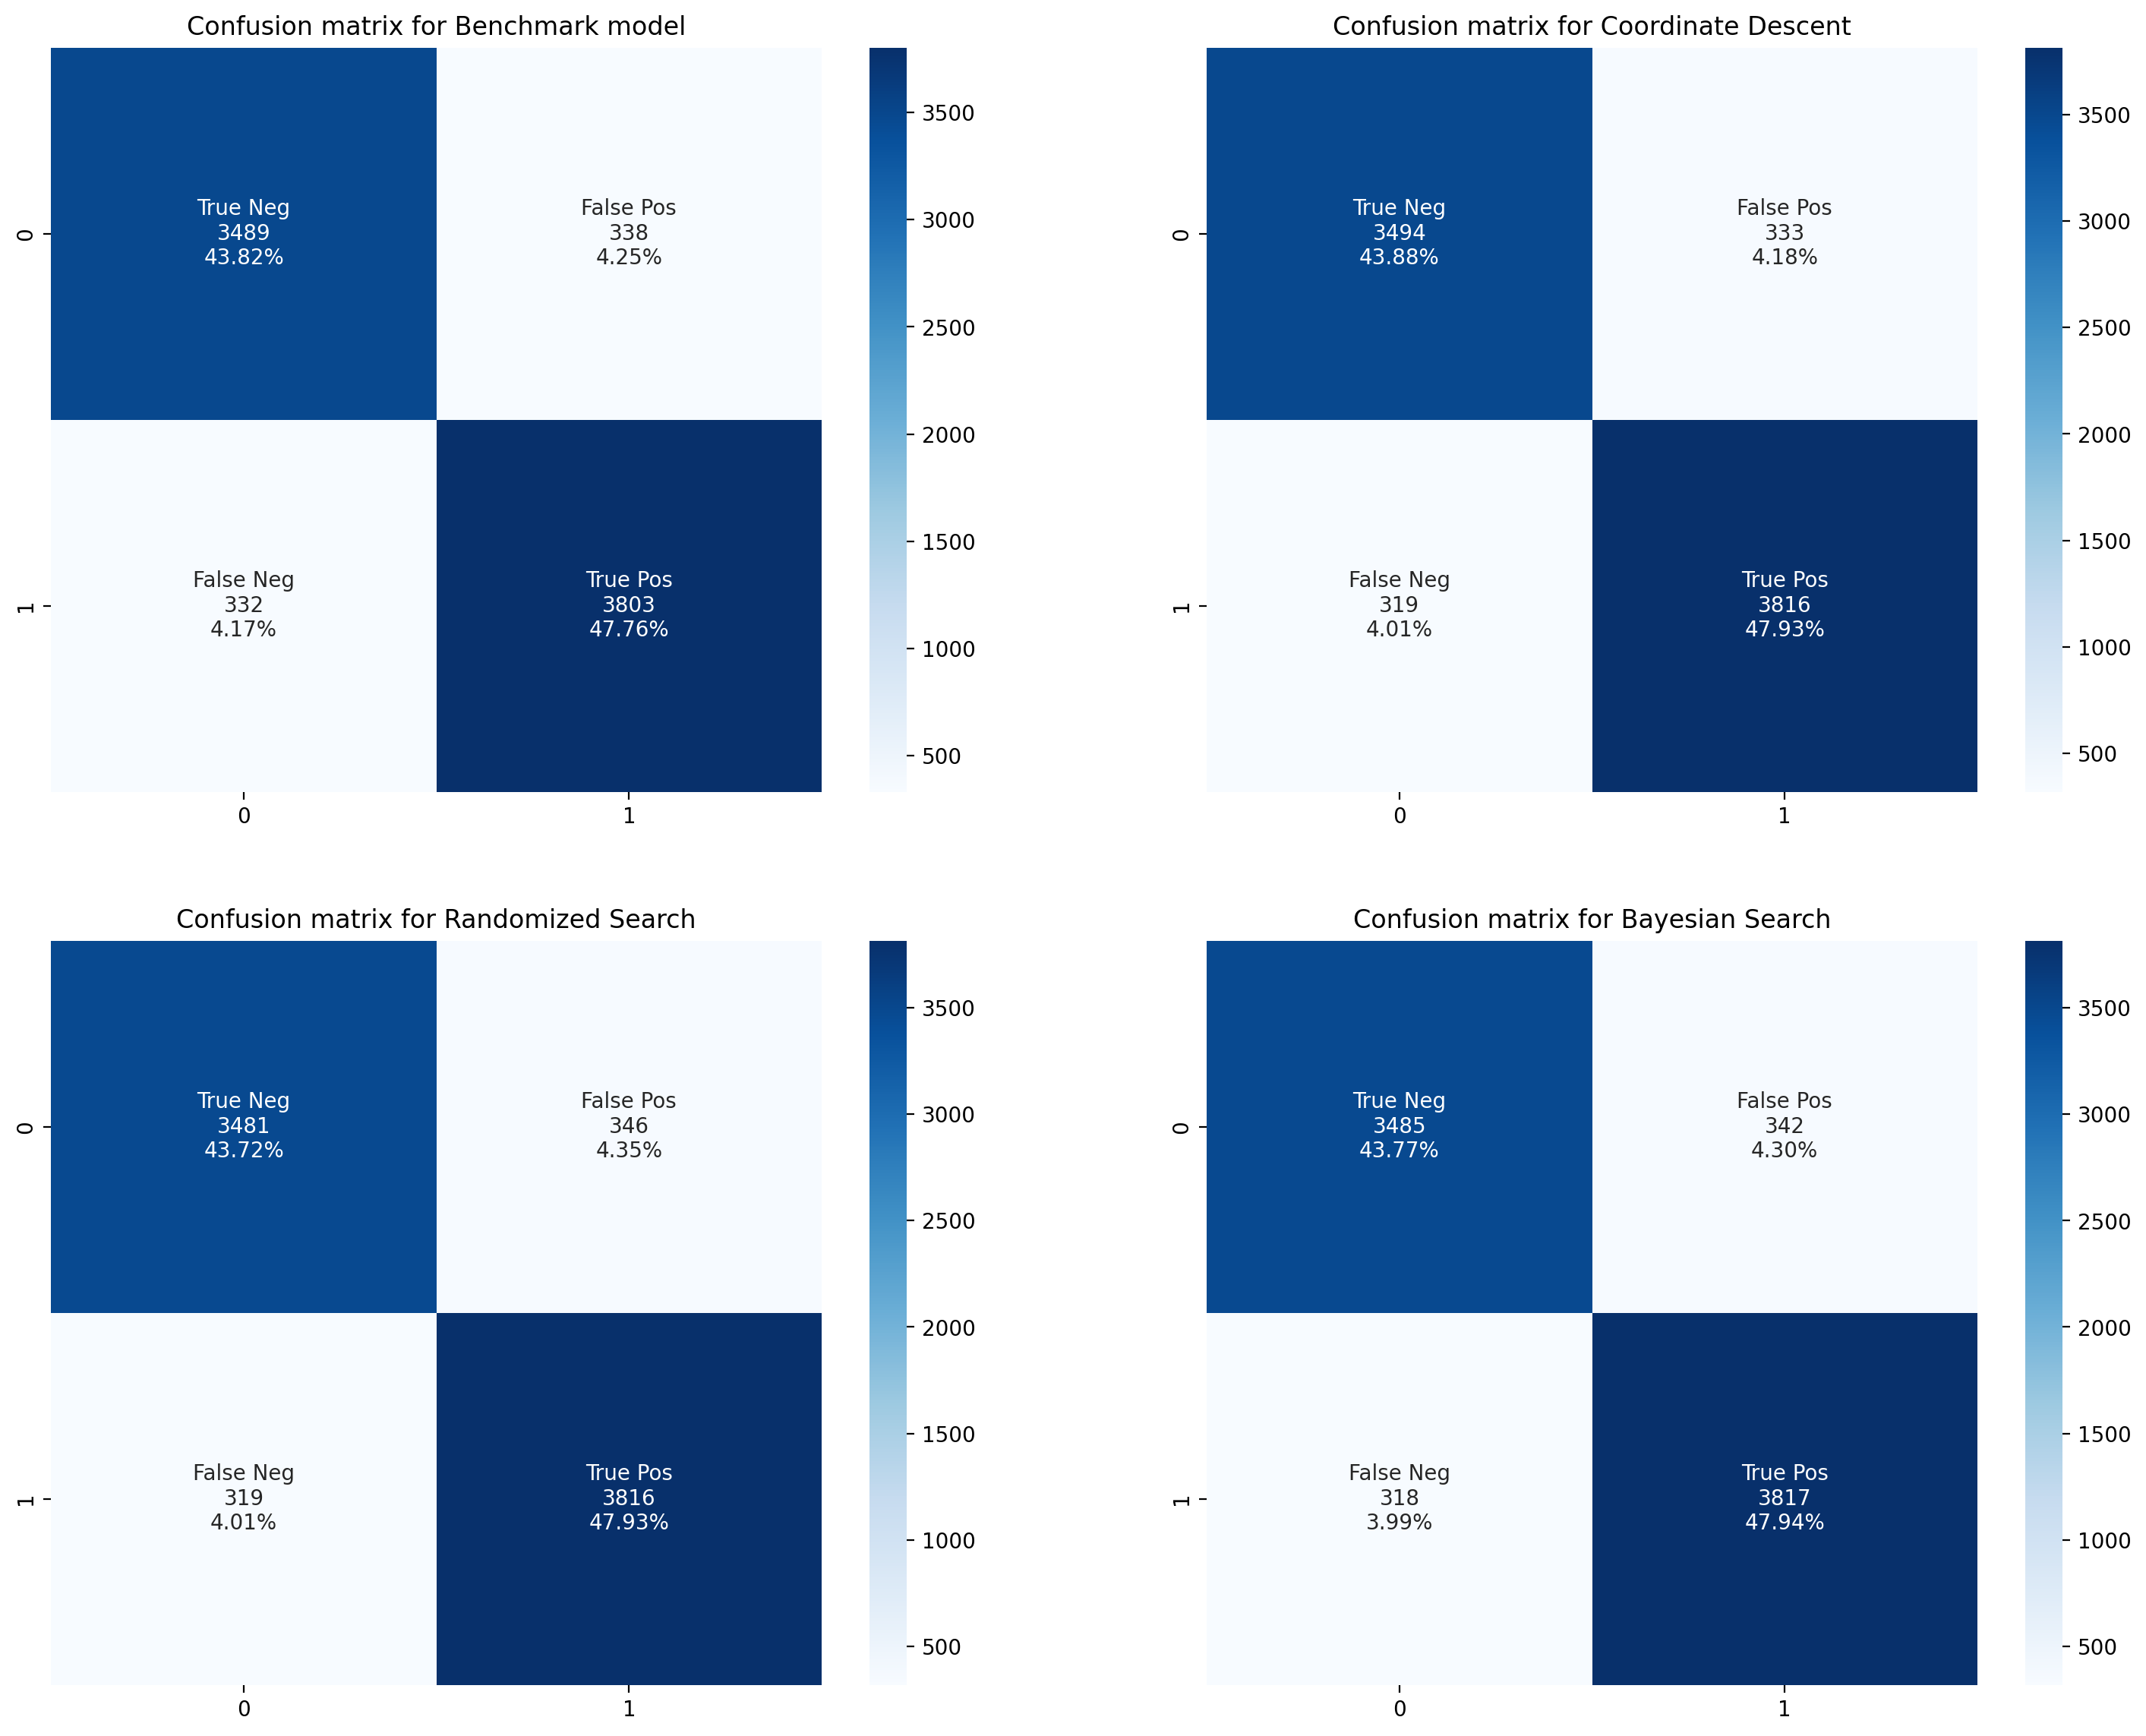

In [113]:

keys = ['xgbc0', 'xgbc6', 'xgbc_rcv', 'xgbc_bcv']
titles = ['Benchmark model', 'Coordinate Descent', 'Randomized Search', 'Bayesian Search']

f, axes = plt.subplots(2,2,figsize=(18,14));

for i,ax in enumerate(axes.flatten()):
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[keys[i]]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[keys[i]]['cfm_test'].flatten()/np.sum(results_dict[keys[i]]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[keys[i]]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion matrix for {titles[i]}")

Comments 

max_depth   

The maximum depth of a tree, same as GBM.It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.Increasing this value will make the model more complex and more likely to overfit.

gamma

A node is split only when the resulting split gives a positive reduction in the loss function.
Gamma specifies the minimum loss reduction required to make a split.
It makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
The larger gamma is, the more conservative the algorithm will be.

reg_alpha

L1 regularization term on weights (analogous to Lasso regression).
It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.
Increasing this value will make model more conservative.

reg_lambda

L2 regularization term on weights (analogous to Ridge regression).
This is used to handle the regularization part of XGBoost.
Increasing this value will make model more conservative.

colsample_bytree

the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

min_child_weight 

It defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
It is used to control over-fitting.
Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting.
Hence, it should be tuned using CV.
The larger min_child_weight is, the more conservative the algorithm will be.

# Predicting bots on our dataset given model trained in csverlee data 
We are setting a high threshold on 'bot detection', so we won't delete any real users on our dataset

In [3]:
import sqlite3
import pickle
from tqdm import tqdm
import numpy as np

In [8]:
with open('/g100_work/IscrC_mental/data/user_classification/user_age_gender_location_test_set.pkl', 'rb') as file:
    data_test = pickle.load(file)

In [9]:
with open('/g100_work/IscrC_mental/data/user_classification/user_age_gender_location_train_set.pkl', 'rb') as file:
    data_train = pickle.load(file)

In [10]:
with open('/g100_work/IscrC_mental/data/user_classification/tweets_by_user_id_clean.pkl', 'rb') as file:
    tweets = pickle.load(file)

In [8]:
### to big dataset, use only test set 
#users_df = pd.concat([data_test, data_train], ignore_index = False)
#users = users_df[['user_id', 'following','followers','username','status']]

In [11]:
users = data_test[['user_id', 'following','followers','username','status']]

In [12]:
tweets = tweets.merge(users, on = 'user_id', how = 'inner')

In [13]:
### Time variables
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

tweets['rounded_15min'] = tweets['created_at'].dt.floor('15min')
tweet_counts = tweets.groupby(['user_id', 'rounded_15min']).size().reset_index(name='tweet_count')

user_summary_15min = tweet_counts.groupby('user_id')['tweet_count'].agg(['max', 'min', 'std', 'mean']).reset_index()
user_summary_15min.rename(columns={'max': 'max_tweets_15min', 'min': 'min_tweets_15min', 'std':'std_tweets_15_min', 'mean':'mean_tweets_15min'}, inplace=True)

users = users.merge(user_summary_15min, on='user_id', how='left')

In [14]:
tqdm.pandas()

tweets['text'] = tweets['text'].apply(lambda x: str(x) if isinstance(x, (str, float)) else '')
tweets['word_count'] = tweets['text'].str.split().progress_apply(len)

ser_mean_word_count = tweets.groupby('user_id')['word_count'].agg(['mean', 'std']).reset_index()
ser_mean_word_count.rename(columns={'mean': 'mean_word_count', 'std': 'std_word_count'}, inplace=True)


users = users.merge(ser_mean_word_count, on='user_id', how='left')


100%|██████████| 1571178/1571178 [00:01<00:00, 1162972.80it/s]


In [15]:
## Mentions
tweets['mentions_count'] = tweets['text'].str.count('@')
mentions_count = tweets.groupby('user_id')['mentions_count'].agg(['mean', 'std']).reset_index()
mentions_count.rename(columns={'mean': 'mean_mentions_count', 'std':'std_mentions_count'}, inplace=True)
users = users.merge(mentions_count, on='user_id', how='left')

In [16]:
## Hashtags
tweets['hashtags_counts'] = tweets['text'].str.count('#')
hashtag_count = tweets.groupby('user_id')['mentions_count'].agg(['mean', 'std']).reset_index()
hashtag_count.rename(columns={'mean': 'mean_hashtag_count', 'std':'std_hashtag_count'}, inplace=True)
users = users.merge(hashtag_count, on='user_id', how='left')

In [17]:
## URls
tweets['urls_counts'] = tweets['text'].str.count('http')
hashtag_count = tweets.groupby('user_id')['urls_counts'].agg(['mean', 'std']).reset_index()
hashtag_count.rename(columns={'mean': 'mean_urls_count', 'std':'std_urls_count'}, inplace=True)
users = users.merge(hashtag_count, on='user_id', how='left')

In [18]:
## followers to following ratio
users['followers_to_following'] = np.where(users['following'] == 0, np.nan, users['followers'] / users['following'])

In [20]:
users['length_screen_name'] = users['username'].apply(len)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
users = users.merge(data_test[['masked_bio', 'user_id']], on='user_id')

In [27]:
users = users.drop(columns=['masked_bio'])

In [25]:
users['length_description'] = users['masked_bio'].apply(len)

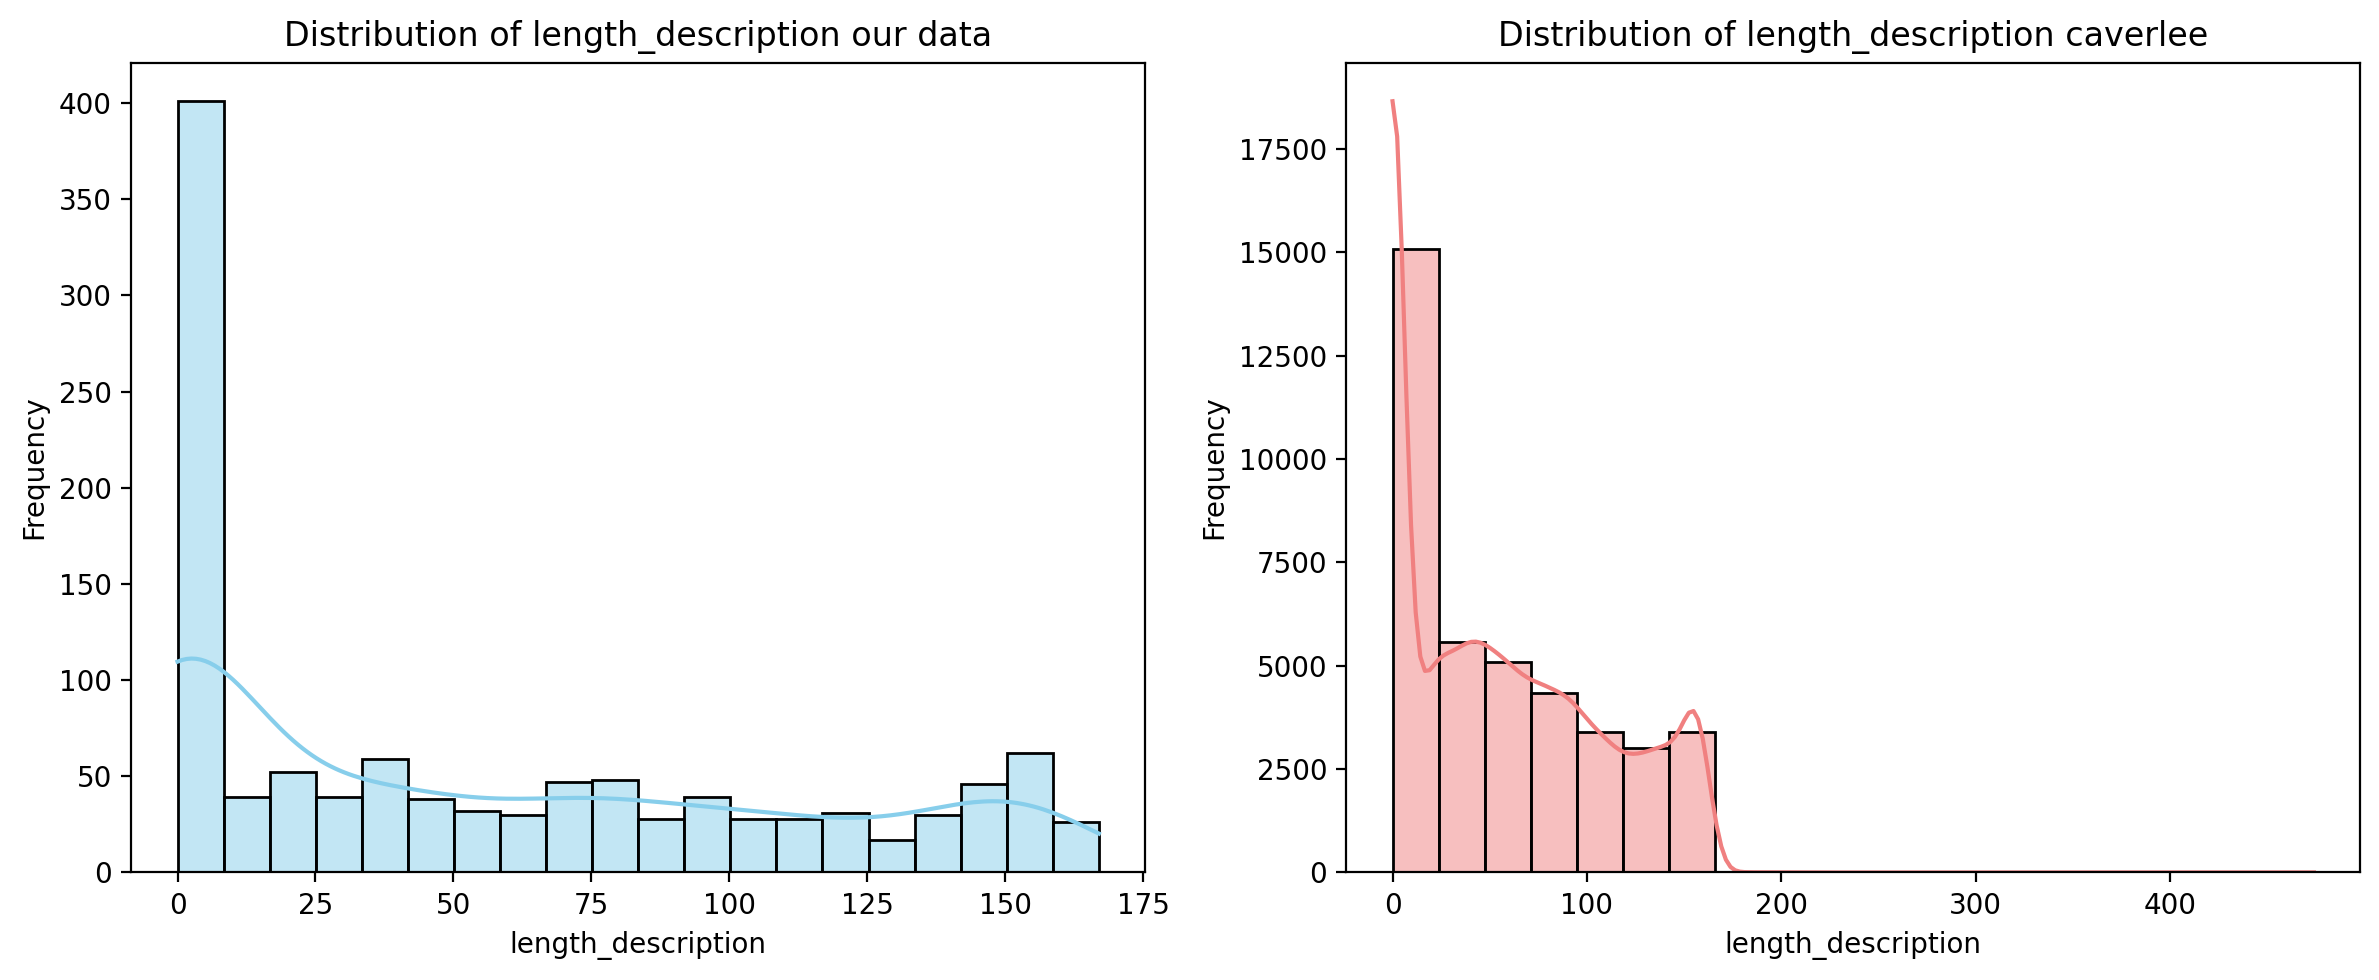

In [55]:
### checked distribution is the same, right distribution

column1 = 'length_description'
column2 = 'length_description'
data1 = users['length_description']
data2 = df_pred_caverlee['length_description']


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# the first distribution
sns.histplot(data1, bins=20, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title(f'Distribution of {column1} our data')
axes[0].set_xlabel(column1)
axes[0].set_ylabel('Frequency')

# the second distribution
sns.histplot(data2, bins=20, kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title(f'Distribution of {column2} caverlee')
axes[1].set_xlabel(column2)
axes[1].set_ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [59]:
users = users.drop(columns = ['username', 'masked_bio'])
users = users.drop(columns = ['status'])
users.to_csv('test_data_for_prediction.csv', index=False)

In [47]:
df_pred = pd.read_csv('test_data_for_prediction.csv')
X_users = users.drop(columns = ['user_id', 'status', 'username'])


In [51]:
clf = joblib.load('randomized_search_model.pkl')
predictions = clf.predict(X_users)

In [52]:
pred_df =users
pred_df['bot_pr'] = predictions

In [56]:
class_probabilities = clf.predict_proba(X_users)

In [59]:
df_class_prob = pd.DataFrame(data=class_probabilities, columns=['not_bot', 'bot'])

In [60]:
pred_df = pd.concat([pred_df, df_class_prob ], axis=1)

In [64]:
pred_df[pred_df['bot']>0.95]

,user_id,following,followers,username,status,max_tweets_15min,min_tweets_15min,std_tweets_15_min,mean_tweets_15min,mean_word_count,...,mean_hashtag_count,std_hashtag_count,mean_urls_count,std_urls_count,followers_to_following,length_screen_name,length_description,bot_pr,not_bot,bot
55,497714759,200,99,vitoluisi,processed,9,1,1.046463,1.493213,10.287121,...,0.000758,0.027524,0.0,0.0,0.495000,9,0,1,0.041385,0.958615
74,736657903764013056,170,114,leonardiross1,processed,8,1,1.270985,1.905289,17.804390,...,0.000000,0.000000,0.0,0.0,0.670588,13,0,1,0.041428,0.958572
138,243690851,112,65,raeleantonino,processed,15,1,2.157354,2.369452,14.234160,...,0.000000,0.000000,0.0,0.0,0.580357,13,0,1,0.046348,0.953652
388,2763833896,184,46,GuardiniLoris,processed,13,1,2.159034,3.346398,17.835708,...,0.000000,0.000000,0.0,0.0,0.250000,13,0,1,0.047910,0.952090
510,77469899,96,81,pinosarno,processed,8,1,0.380860,1.039110,5.721033,...,0.002214,0.047019,0.0,0.0,0.843750,9,0,1,0.045549,0.954451
615,1304250632,94,50,LalliBlanc,processed,11,1,1.356397,2.012528,14.296595,...,0.000000,0.000000,0.0,0.0,0.531915,10,0,1,0.046805,0.953195
657,1304584058668806144,173,29,Luca230783,processed,16,1,1.393129,1.728059,7.378398,...,0.000000,0.000000,0.0,0.0,0.167630,10,0,1,0.048001,0.951999
673,1657200685,173,98,botta_ale,processed,8,1,0.762686,1.305022,7.606678,...,0.000000,0.000000,0.0,0.0,0.566474,9,0,1,0.041962,0.958038
960,819290738580221952,116,56,Gino53301512,processed,12,1,1.700882,2.397341,12.551140,...,0.000000,0.000000,0.0,0.0,0.482759,12,0,1,0.047625,0.952375
1075,978068257,174,21,gynomeoli,processed,17,1,1.554016,1.632124,13.553968,...,0.000000,0.000000,0.0,0.0,0.120690,9,0,1,0.048001,0.951999
